# COGS 118B - Final Project

# Contributing Factors to Obesity

## Group members

- Pallavi Gaikwad
- Katelyn Vu
- Austin Jung
- William Kim
- Kayla Nguyen

# Abstract 
Our goal is to analyze and identify the salient eating habits, lifestyle choices, and any genetic predispositions of individuals that generally lead to obesity. We are using tabular data from the UCI Machine Learning Data Repository with data about individuals and obesity from Mexico, Peru, and Colombia. Some of the metrics in the dataset include family history of overweight, daily meal count, and time spent physically active. We plan to use an unsupervised machine learning model to identify any trends or clustering of data, specifically k-means clustering if the data have similar variance. We plan to evaluate the performance of the model using silhouette scores to see the frequency of data within and cluster and the distance of clusters from each other. If we see that there are certain factors that correlate amongst points in clusters, we may be able to conclude stronger associations between those points and certain types of obesity.



# Background
Obesity is a widespread global health crisis that causes severe health complications and costs billions of dollars annually in treatments. As of 2016, about 340 million people were classified as obese and 1.9 billion were classified as overweight<a name="who"></a>[<sup>[1]</sup>](#who). In the United States, obesity disproportionately affects certain racial groups at higher rates; non-Hispanic Black adults showed an obesity prevalence of roughly 49% and Hispanic adults showed an obesity prevalence of roughly 45%<a name="cdc"></a>[<sup>[2]</sup>](#cdc). Obesity also demonstrates higher rates of prevalence based on socioeconomic status, with college graduates showing lower rates of obesity when compared to adults with less education─this further breaks down when taking into account sex and race. This epidemic does not solely apply to adults as roughly 340 million children were diagnosed as either obese or overweight in 2016<a name="who"></a>[<sup>[1]</sup>](#who).

These staggering proportions are extremely alarming as obesity increases the risk of other severe health conditions, such as heart disease, stroke, type II diabetes, and some types of cancer (colon, prostate, and rectum cancer in men and breast, uterine, and gallbladder cancer in women)<a name="niddk"></a>[<sup>[3]</sup>](#niddk). Not only are these conditions harmful, they also increase financial burden. In the United States, those who are overweight or obese pay on average $2000 more annually in healthcare costs than those at healthy weights<a name="cdc"></a>[<sup>[2]</sup>](#cdc). 

Even with these sobering statistics, obesity trends have continued to increase amongst all age groups, sexes, and racial groups, with global obesity nearly tripling since 1975<a name="who"></a>[<sup>[1]</sup>](#who). The causes of obesity are a mix of both genetic and environmental factors, such as diet, physical activity, and sedentary behavior.  This is an extremely prevalent issue and one of the most pressing healthcare crises facing Americans, so in this project we hope to see which factors may be contributing more to obesity prevalence.

# Problem Statement

Our team’s objective is to analyze and identify the salient eating habits, lifestyle choices, and physical traits of individuals that generally lead to certain types of obesity. This challenge involves the development of a machine learning model capable of segmenting our observations into distinct groups. We can then use our findings on underlying relationships between variables to determine what generally leads to certain types of obesity, by looking at the distribution of Body Mass Indexes in each subpopulation.

# Data

Our dataset was pulled from the UCI Machine Learning Repository. A link to this can be found <a href='https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition'>here</a>. The dataset itself is the result of a survey that collected information on obesity levels from individuals in the countries of Mexico, Peru, and Colombia.

It contains 2111 records containing 17 attributes:
- Gender: Male, Female
- Age: Numeric
- Height: Numeric in meters
- Weight: Numeric in kilograms
- Family_history_with_overweight: Yes, No
- FAVC (Do you eat high caloric food): Yes, No
- FCVC (Do you usually eat vegetables): Yes, No
- NCP (How many meals do you have daily): Between 1 and 2, Three, More than three
- CAEC (Do you eat food between meals): No, Sometimes, Frequently, Always
- SMOKE (Do you smoke): Yes, No
- CH2O (How much water do you drink):  Less than a liter, Between 1 and 2L, More than 2L
- SCC (Do you monitor your calories): Yes, No
- FAF (How often do you have physical activity): I do not have, 1 or 2 days, 2 or 5 days, 4 or 5 days
- TUE (How much time do you use technological devices): 0-2 hours, 3-5 hours, More than 5 hours
- MTRANS (How often do you drink alcohol): I do not drink, Sometimes, Frequently, Always
- NObeyesdad (Which transportation do you usually use): Automobile, Motorbike, Bike, Public Transportations, Walking)

One important aspect of this is that the researchers utilized a synthetic minority over-sampling technique to generate additional data in order to balance the number of identifiable samples for each type of obesity. This was done to decrease bias in future learning approaches.


## Data Cleaning

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from umap import UMAP 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, adjusted_rand_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.cluster import DBSCAN
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# suppresses annoying errors
import os
import sys

# Redirect stderr to /dev/null (Linux/macOS) or nul (Windows)
if os.name == 'posix':
    sys.stderr = open(os.devnull, 'w')
elif os.name == 'nt':
    sys.stderr = open('nul', 'w')

In [14]:
# reading in dataset
obesity=pd.read_csv('obesity.csv')
# renaming the variable columns
obesity.rename(columns={'family_history_with_overweight': 'Family Obesity', 
                        'FAVC': 'High Calories', 
                        'FCVC': 'Vegetables', 
                        'NCP': 'Meals',
                        'CAEC': 'Food Between Meals',
                        'SMOKE': 'Smoke',
                        'CH2O': 'Water',
                        'SCC': 'Monitor Calories',
                        'FAF': 'Excercise',
                        'TUE': 'Technology',
                        'CALC': 'Alcohol',
                        'MTRANS': 'Transportation Movement'
                        }, inplace=True)


#### Variables

- `Gender`: categorical (male, female)
- `Age`: discrete numerical
- `Height`: continuous numerical
- `Weight`: continous numerical
- `Family Obesity`: categorical (History of Family Obesity)
- `High Calories`: categorical (Frequent High Calorie Consumption)
- `Vegetables`: continuous (Frequency of Vegetable Consumption)
- `Meals`: continous (Daily Meal Count)

In [15]:
# clean vegetables column
obesity['Meals'].value_counts()

Meals
3.000000    1203
1.000000     199
4.000000      69
2.776840       2
3.985442       2
            ... 
3.054899       1
3.118013       1
3.335876       1
3.205009       1
1.089048       1
Name: count, Length: 635, dtype: int64

In [16]:
categorical_mapping = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3 }
obesity['Alcohol'] = obesity['Alcohol'].map(categorical_mapping)
obesity['Food Between Meals'] = obesity['Food Between Meals'].map(categorical_mapping)

numerical_columns = ['Age', 'Height', 'Weight', 'Vegetables', 'Meals', 'Food Between Meals', 'Water', 'Excercise', 'Technology', 'Alcohol']
scaler = StandardScaler()
obesity[numerical_columns] = scaler.fit_transform(obesity[numerical_columns])


In [17]:
# Identify the categorical columns to be one-hot encoded
categorical_columns = ['Gender', 'Family Obesity', 'High Calories', 'Smoke', 'Monitor Calories', 'Transportation Movement']

# Perform one-hot encoding
obesity = pd.get_dummies(obesity, columns=categorical_columns)

# Display the encoded DataFrame
obesity.head()

,Age,Height,Weight,Vegetables,Meals,Food Between Meals,Water,Excercise,Technology,Alcohol,...,High Calories_yes,Smoke_no,Smoke_yes,Monitor Calories_no,Monitor Calories_yes,Transportation Movement_Automobile,Transportation Movement_Bike,Transportation Movement_Motorbike,Transportation Movement_Public_Transportation,Transportation Movement_Walking
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.300346,-0.013073,-1.188039,0.561997,-1.419172,...,False,True,False,True,False,False,False,False,True,False
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,-0.300346,1.618759,2.339750,-1.080625,0.521160,...,False,False,True,False,True,False,False,False,True,False
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.300346,-0.013073,1.163820,0.561997,2.461491,...,False,True,False,True,False,False,False,False,True,False
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.300346,-0.013073,1.163820,-1.080625,2.461491,...,False,True,False,True,False,False,False,False,False,True
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.300346,-0.013073,-1.188039,-1.080625,0.521160,...,False,True,False,True,False,False,False,False,True,False


In [18]:
# obesity_labels = obesity.columns.tolist()
obesity_labels = obesity['NObeyesdad']
Cleaned_Data = obesity.drop('NObeyesdad', axis=1)
y = obesity['NObeyesdad']
print(obesity_labels)

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object


# Proposed Solution
To address the problem of identifying factors contributing to different levels of obesity, we propose that we will be able to utilize k-means clustering based on eating habits, lifestyle choices, and physical traits. This algorithm allows us to partition our data into predetermined clusters where each data point, or individual, will belong to one level of obesity. This will allow us to uncover underlying patterns within the dataset. 

The data set that we have chosen to use comprises various features related to eating habits, lifestyle,  physical traits, and corresponding Body Mass Indexes (BMIs) of individuals. These features will allow us to perform analysis that will capture the determinants of obesity. Since K means relies on the calculation of distances between data points, we will have to preprocess the data to ensure that it is appropriately scaled and normalized.  We will apply the algorithm to segment the dataset into distinct groups based on similarities in the features. Assuming that we find the number of clusters that maximize intra-cluster similarity and inter-cluster dissimilarity, we will be able to analyze the characteristics of each cluster to identify common trends associated with different types of obesity. To test our solution we will split the data set into testing and training subsets and compare the results of our model and existing knowledge of obesity.

Overall, our solution aims to provide insights for public health strategies that can prevent and manage obesity levels. It will allow us to identify distinct groups of individuals based on different features and enable a deeper understanding of the factors that contribute to different types of obesity.

# Evaluation Metrics
The main evaluation metric that will be used for both the benchmark and solution model is the silhouette score. By using the separation distance between the clusters within the model, we can determine the optimal number of clusters. The two categories to take into account are the thickness of the silhouette scores plotted (namely how thick they are compared to the other clusters’ scores), and how close the silhouette scores of each cluster is to 1, which would indicate that the cluster is far away from the other clusters.

In order to calculate the silhouette coefficient for each of the samples, we need to find the following: the mean intra-cluster distance (a) and the mean nearest-cluster distance (b). To find these two distances, we would use the distance formula between each of the points in the cluster with all other points in the cluster. Therefore, $$a(i) =\frac{ \sum_{j \in C_i, j\neq i}dist(i,j)}{N_i-1}$$
for each sample $i$, in cluster $C_i$, where $j$ is the other points within $C_i$, and $N_i$ is the total number of samples within $C_i$.

On the other hand, we can find b with a similar method, except instead for each of the other points within the same cluster, we use the points in the closest cluster. That would mean:
$$b(i) = min_{k\neq i} \frac{\sum_{j\in C_k}dist(i,j)}{N_k}$$
where $N_k$ is the number of samples in the nearest cluster to $i$.

Lastly, you would find the silhouette score for the total cluster by using the averages of all of the as and bs to get $$s = \frac{b(avg) - a(avg)}{max(a,b)}$$
where s is the silhouette score.

We would take the average silhouette score for each of the clusters to find out overall how good our models are. In an ideal world, the score would be a 1, which would be a perfect score, but we imagine a score of above 0.5 will be high enough to conclude the model worked to a certain extent.

# Results




### Subsection 1: Data Visualization and Model Selection

The dataset that we have provided showcases seventeen variables that are possible contributors to different levels of obesity. To determine what model woul be effecient, we performed data visualization using PCA, UMAP, and tSNE. Of these three methods, tSNE allowed us to infer the most. Our PCA visualization resulted in a plot with many overlapping points, making it difficult to differentiate between different types of obesity. The UMAP visualization plotted a tightly packed cluster that was not useful for our analysis. The tSNE visualization exhibits a better representation, it captures the local relationships between points, however the data does not seem to adhere to the classic assumptions of classic models. Due to the distribution of the data being high dimensional, we came to the conclusion that Kmeans and KNN would not be our best algorithm to use.

Below is our code spliting our data set into training and testing sets, utilizing this we performed tSNE.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X = Cleaned_Data
y = y
 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


In [20]:
#Preview of the labels
y

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object

In [21]:
# Preview of the training dataset
X_train

,Age,Height,Weight,Vegetables,Meals,Food Between Meals,Water,Excercise,Technology,Alcohol,...,High Calories_yes,Smoke_no,Smoke_yes,Monitor Calories_no,Monitor Calories_yes,Transportation Movement_Automobile,Transportation Movement_Bike,Transportation Movement_Motorbike,Transportation Movement_Public_Transportation,Transportation Movement_Walking
1295,2.180837,-1.542294,-0.264440,-0.785019,0.404153,-0.300346,-1.196520,-1.188039,-1.080625,0.521160,...,True,True,False,True,False,True,False,False,False,False
1627,2.530338,0.222106,0.869314,-0.256800,1.394543,-0.300346,-1.644905,0.376558,-1.080625,-1.419172,...,True,True,False,True,False,True,False,False,False,False
1388,2.417280,-1.381675,-0.248216,-0.650845,0.375753,-0.300346,-0.880723,-1.188039,-1.080625,-1.419172,...,True,True,False,True,False,True,False,False,False,False
1318,-0.169486,0.636030,0.429379,-0.785019,0.404153,-0.300346,1.600435,1.669380,2.168551,-1.419172,...,True,True,False,True,False,False,False,False,True,False
648,-0.278243,0.222803,-1.325371,0.457808,0.404153,1.834434,-1.577820,-0.253878,1.205819,-1.419172,...,True,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,-0.731460,-0.023620,-0.327900,-0.925401,-0.420811,-0.300346,1.250035,-1.188039,-0.861226,-1.419172,...,False,True,False,True,False,False,False,False,True,False
1731,0.983906,0.830364,1.299023,0.472452,0.404153,-0.300346,0.224143,-0.150035,-0.105044,0.521160,...,True,True,False,True,False,True,False,False,False,False
763,-0.522124,-0.875589,-0.633419,-0.785019,-2.167023,-2.435125,1.618759,-0.012109,-1.080625,0.521160,...,True,True,False,True,False,False,False,False,True,False
835,0.789315,-0.634323,-0.636982,-0.097591,0.404153,-0.300346,-0.132887,0.671390,-1.080625,0.521160,...,True,True,False,True,False,True,False,False,False,False


### tSNE Visualization
Below this code transforms the training data (X_train) into two dimensions using t-SNE with a perplexity of 20 and a random state of 99. The resulting two-dimensional representation is stored in a DataFrame (tcs), with additional labels denoting the obesity type extracted from the target variable (y_train). The code then plots this transformed data, where each point is colored according to its ground truth obesity type. This visualization aids in understanding the underlying structure of the data and the distribution of different obesity types

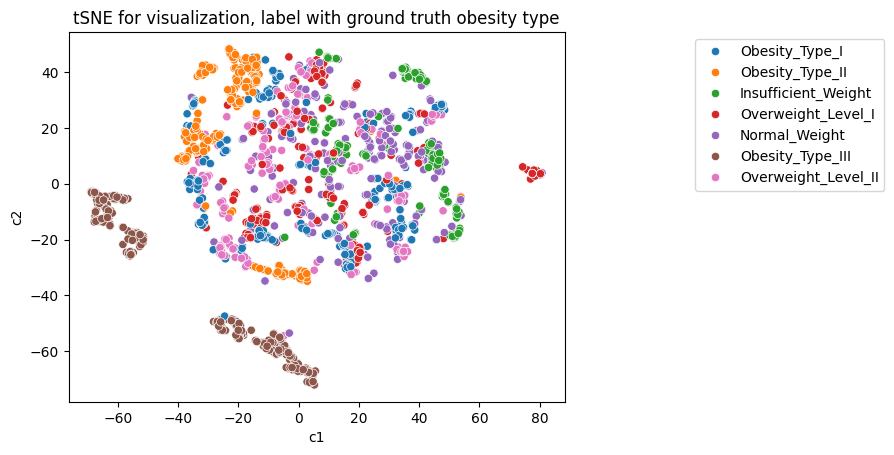

In [22]:
tsne_perp_20 = TSNE(n_components = 2, perplexity = 20, random_state = 99)
tcs = tsne_perp_20.fit_transform(X_train)
# construct the data frame
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = X_train.index

tcs['obesity_type'] = y_train

sns.scatterplot(data=tcs, x='c1', y='c2', hue='obesity_type')
plt.title('tSNE for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1))



### KMeans Model
Utilizing the kneelocator method, we can visualize the graph across a range of clusters to pinpoint where the decline in clusters occurs. This visual assessment aids in determining an optimal number of clusters for our dataset. By identifying the point where the rate of change diminishes significantly, we can establish a suitable range of clusters for subsequent analysis. This approach enhances our ability to select an appropriate number of clusters, contributing to the effectiveness of our clustering algorithm


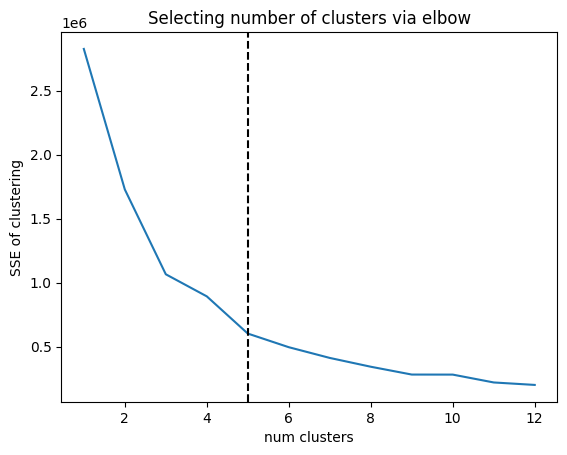

In [25]:
import sklearn.cluster as cluster
from kneed import KneeLocator

tsne = TSNE(n_components=2, perplexity=20, method='barnes_hut', n_iter=1000, random_state=99)
tcs = tsne.fit_transform(X_train)
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = X_train.index
sse=[]

maxk = 13
for k in range(1,maxk):
    clust = cluster.KMeans(n_clusters=k)
    clust.fit(tcs)
    sse.append(clust.inertia_)

# finds the location of max curvature
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="black", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');


The code below performs silhouette analysis for KMeans clustering on the high-dimensional data represented by X_train. It iterates over a range of cluster numbers (3, 4, and 5), creating silhouette plots to assess the quality of clustering. The plots visualize these coefficients for each cluster, with the average silhouette score marked by a dashed red line. Additionally, the code applies KMeans clustering to the high-dimensional data and visualizes the resulting clusters on a t-SNE transformed two-dimensional space (c1 and c2).

For n_clusters = 3 The average silhouette_score is : 0.1251921814921334
For n_clusters = 4 The average silhouette_score is : 0.134411129439368
For n_clusters = 5 The average silhouette_score is : 0.13128396736030623


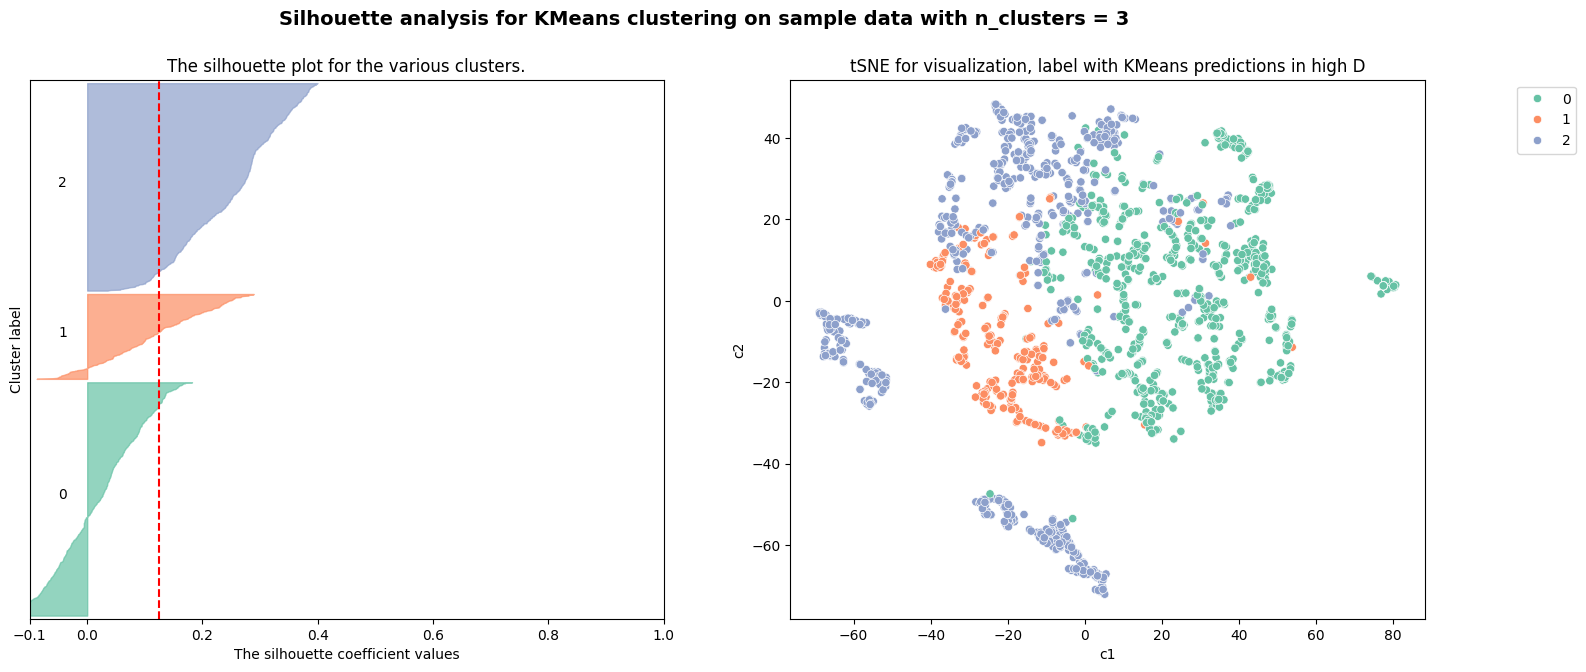

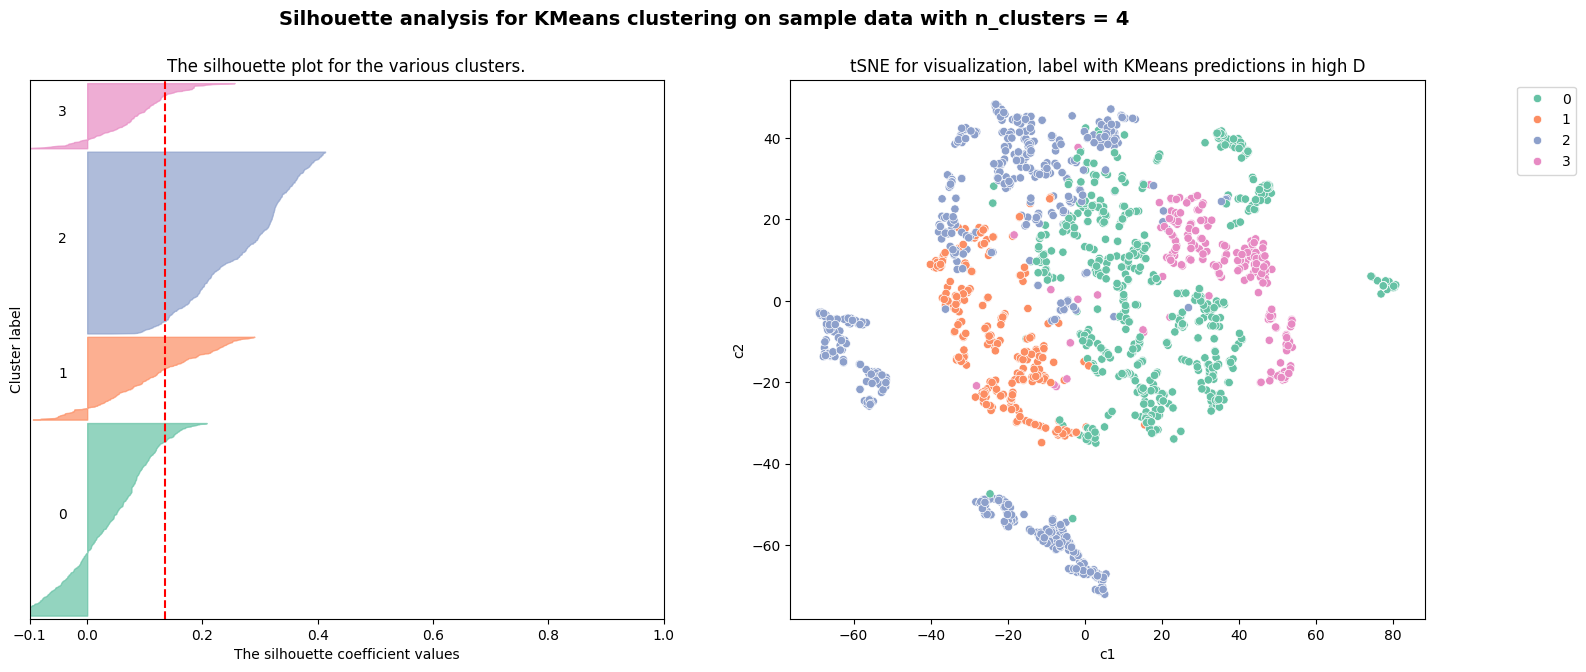

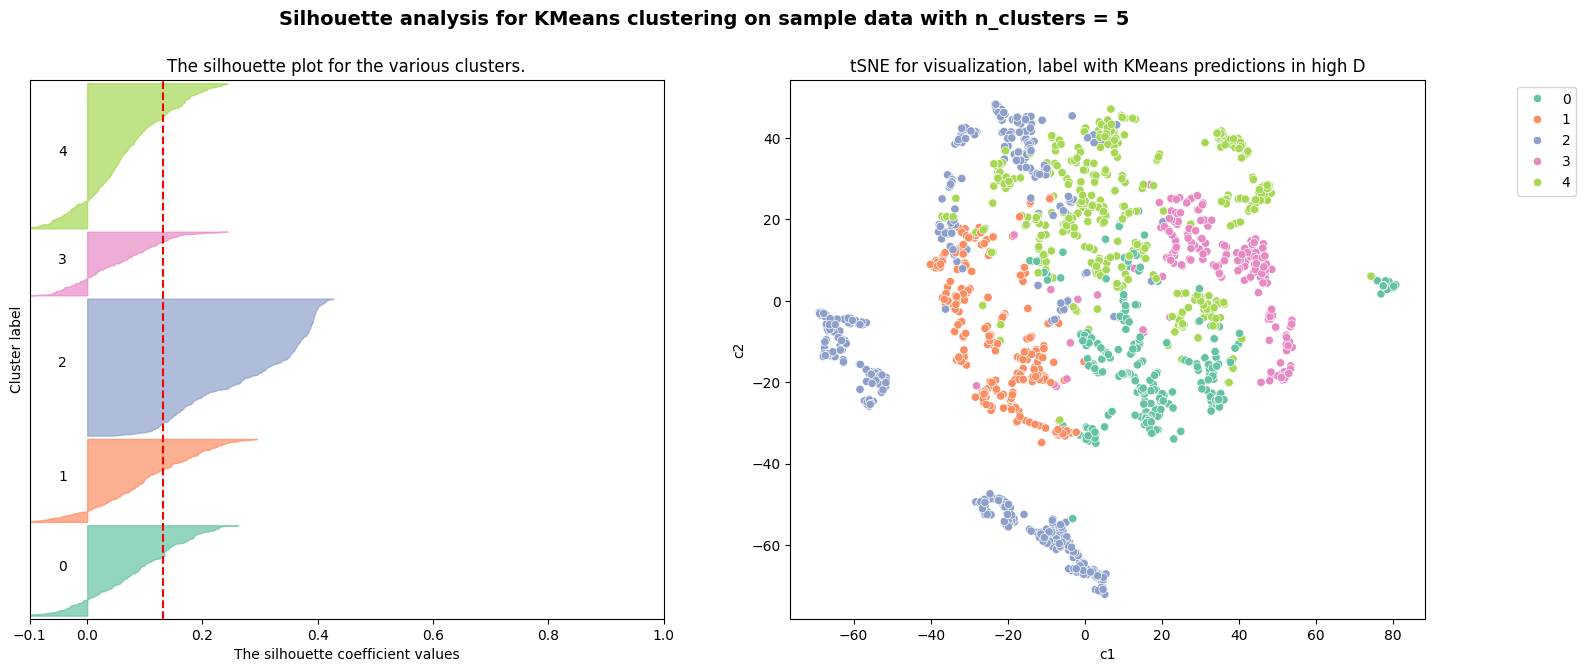

In [26]:
##copy/pasted from lecture notebook 19 and edited to be used for our data
### copy/pasted with some mods from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X= X_train.values #turn into numpy

range_n_clusters = [3, 4, 5] #Determined by the elbow above

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = sns.color_palette('Set2', n_clusters)[i]
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    predicted = clusterer.predict(X)
    tcs['prediction'] = predicted
    sns.scatterplot(data=tcs, x='c1', y='c2', hue='prediction', 
                    palette='Set2', ax=ax2)
    plt.title('tSNE for visualization, label with KMeans predictions in high D')
    ax2.legend(bbox_to_anchor=(1.25, 1));

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In analyzing the silhouette plots generated from the KMeans clustering algorithm, it becomes evident that this method may not be suitable for our dataset. The observed discrepancies in silhouette shapes across different cluster numbers suggest a lack of clear separation between clusters. Consistent with our previous exploration using t-SNE, this indicates that KMeans may not effectively capture the underlying structure of our data. As a result, we will explore alternative clustering techniques, starting with DBSCAN, to better uncover meaningful patterns within our dataset.

## Subsection 2: DBSCAN 
Following the t-SNE transformation of our data, our next step involves assessing the local density of data points. We achieve this by employing the Nearest Neighbors model to measure the proximity between points. Identifying the 'elbow' in the distance plot allows us to determine an appropriate starting point for the epsilon (eps) value when configuring our DBSCAN algorithm. This approach enables us to initiate DBSCAN clustering with a well-informed parameter setting, thereby enhancing our ability to uncover meaningful clusters within the data.

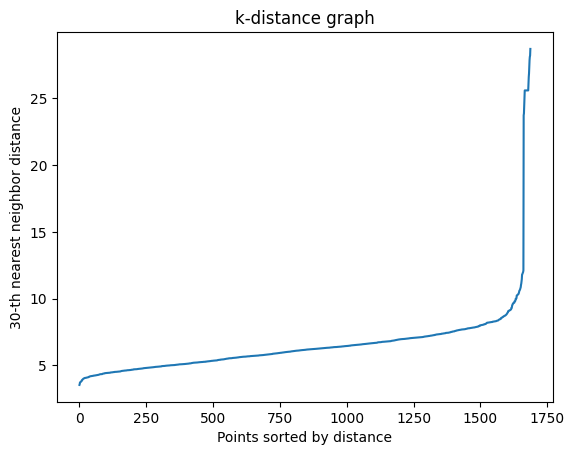

In [27]:
tsne = TSNE(n_components=2, perplexity=20, method='barnes_hut', n_iter=1000, random_state=99)
tcs = tsne.fit_transform(X_train)

# Compute the distances to kth nearest neighbors
k = 30  # You may need to adjust this value based on your data
nbrs = NearestNeighbors(n_neighbors=k).fit(tcs)
distances, _ = nbrs.kneighbors(tcs)
distances = np.sort(distances[:, -1])

# Plot the sorted distances
plt.plot(distances)
plt.title('k-distance graph')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.show()


After examining the elbow plot, we observed a sharp increase in distance occurring approximately after k=8. Further experimentation revealed that at k=65, the elbow occurred around 12. To explore various potential epsilon (eps) values, we decided to test a range of values centered around these points. Consequently, we utilized the range between k=2 and k=12, with additional padding, to define the range of eps values for our DBSCAN algorithm. This approach enabled us to thoroughly assess the impact of different eps values on the clustering outcome, ensuring a comprehensive exploration of the parameter space.

In [28]:
best_score = -1
best_params = None

for eps in [8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5]:  # Example values for eps
    for min_samples in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]:  # Example values for min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(tcs)
        dbscan_labels = dbscan.labels_
        
        # Compute adjusted Rand index

        score = adjusted_rand_score(y_train, dbscan_labels)
        print(f"eps={eps}, min_samples={min_samples}, Adjusted Rand Index: {score}")

        # Update best score and parameters
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print("Best parameters:", best_params)
print("Best Adjusted Rand Index:", best_score)




eps=8, min_samples=10, Adjusted Rand Index: 0.08343665355518369
eps=8, min_samples=20, Adjusted Rand Index: 0.08343665355518369
eps=8, min_samples=30, Adjusted Rand Index: 0.0890515033967522
eps=8, min_samples=40, Adjusted Rand Index: 0.12106687421160423
eps=8, min_samples=50, Adjusted Rand Index: 0.08974204350960772
eps=8, min_samples=60, Adjusted Rand Index: 0.05933358346571962
eps=8, min_samples=70, Adjusted Rand Index: 0.03183436285218195
eps=8, min_samples=80, Adjusted Rand Index: 0.0052118498172322265
eps=8, min_samples=90, Adjusted Rand Index: 0.0
eps=8, min_samples=100, Adjusted Rand Index: 0.0
eps=8, min_samples=110, Adjusted Rand Index: 0.0
eps=8, min_samples=120, Adjusted Rand Index: 0.0
eps=8, min_samples=130, Adjusted Rand Index: 0.0
eps=8, min_samples=140, Adjusted Rand Index: 0.0
eps=8, min_samples=150, Adjusted Rand Index: 0.0
eps=8.5, min_samples=10, Adjusted Rand Index: 0.08343665355518369
eps=8.5, min_samples=20, Adjusted Rand Index: 0.08343665355518369
eps=8.5, min_

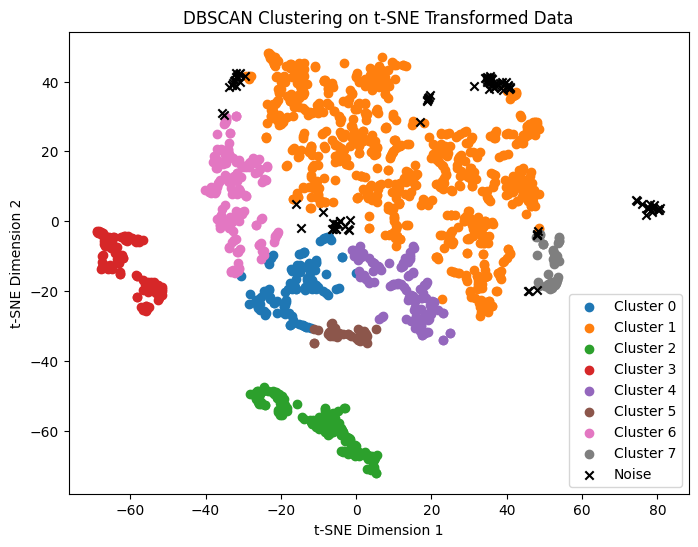

In [29]:
# Apply DBSCAN on the transformed data
dbscan = DBSCAN(eps=8, min_samples=40)
dbscan.fit(tcs)

# Extract cluster labels
cluster_labels = dbscan.labels_

# Number of clusters (ignore noise, represented by -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(tcs[cluster_labels == i][:, 0], tcs[cluster_labels == i][:, 1], label=f'Cluster {i}')
plt.scatter(tcs[cluster_labels == -1][:, 0], tcs[cluster_labels == -1][:, 1], color='black', marker='x', label='Noise')
plt.title('DBSCAN Clustering on t-SNE Transformed Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

### Building Pipeline to Train Models

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification

class TestTSNE(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.n_components = 2
        self.method = 'barnes_hut'
        self.n_iter = 1000
        self.random_state = 99
        self.perplexity = 20

    def fit(self, X, y = None):
        ts = TSNE(n_components = self.n_components, perplexity = self.perplexity, method = self.method, n_iter = self.n_iter, random_state = self.random_state)
        self.embedding_ = ts.fit_transform(X)
        return self

    def transform(self, X, y = None):
        return X
    
    
class DBSCANTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.eps = 13
        self.min_samples = 100

    def fit(self, X, y=None):
        self.dbscan_ = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.dbscan_.fit(X)
        return self

    def transform(self, X):
        return np.column_stack([X, self.dbscan_.labels_])
    
    def predict(self, X):
        return self.dbscan_.fit_predict(X)
    
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=20)

pipe = Pipeline([
    ('tsne', TestTSNE()),
#     ('scaler', scaler),  # Scale the data after dimensionality reduction
    ('dbscan', DBSCANTransformer()),
#     ('knn', knn) # adding knn in the pipeline would perform another classification which is not what we want
])


# if you want to make a pipeline for knn, make a new one

pipe.fit(X_train, y_train)

Pipeline(steps=[('tsne', TestTSNE()), ('dbscan', DBSCANTransformer())])

Text(0, 0.5, 'TSNE Embedding Dimension 2')

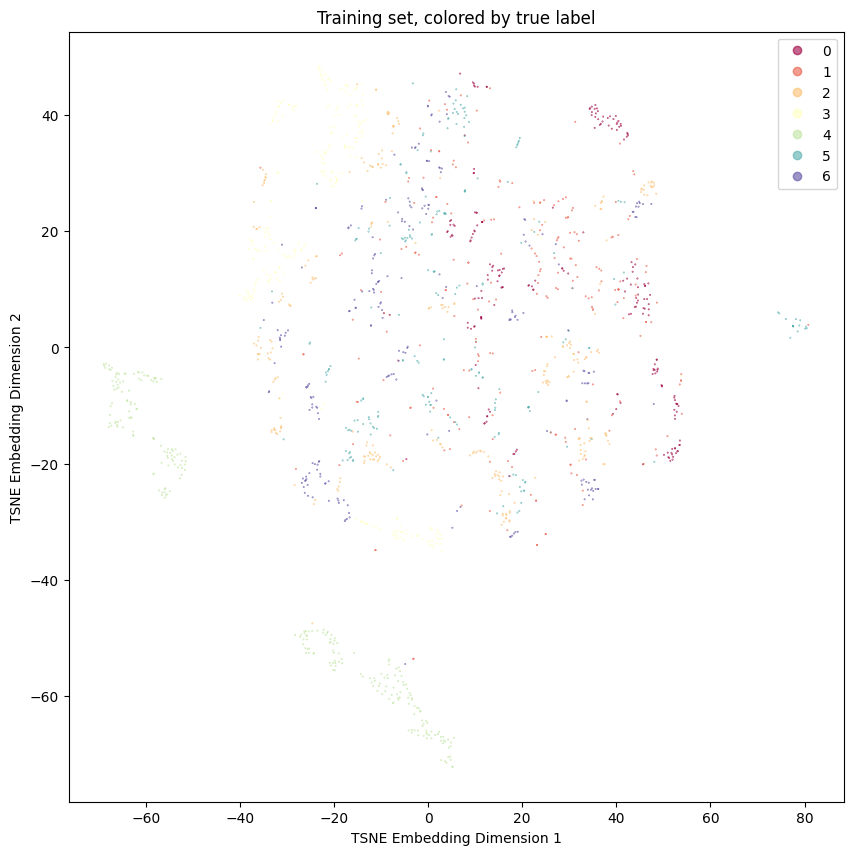

In [31]:
embedding_train = pipe.steps[0][1].embedding_
label_encoder = LabelEncoder()

# Encode categorical labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=y_train_encoded.astype(int), s=0.1, cmap='Spectral')
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6) # use my own labels
legend1 = plt.legend(handles, np.arange(0, 10))
plt.title('Train set, colored by prediction')
plt.title('Training set, colored by true label')
plt.xlabel("TSNE Embedding Dimension 1")
plt.ylabel("TSNE Embedding Dimension 2")

In [32]:
prediction = pipe.predict(X_test)
y_test_encoded = label_encoder.fit_transform(y_test)
prediction_encoded = label_encoder.fit_transform(prediction)
print(classification_report(y_test_encoded, prediction_encoded))

              precision    recall  f1-score   support

           0       0.15      1.00      0.27        65
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        57
           6       0.00      0.00      0.00        55

    accuracy                           0.15       423
   macro avg       0.02      0.14      0.04       423
weighted avg       0.02      0.15      0.04       423



## Subsection 4: Exploring other Models

For our next modeling approach, we considered Hierarchical Clustering. In this test, we opted to perform clustering directly on the original X_train data, rather than on the t-SNE dimension-reduced data. This approach allows us to explore the clustering patterns present in the original feature space. By applying Hierarchical Clustering to the original data, we aim to gain insights into the inherent structure and relationships among the features, potentially uncovering meaningful clusters that may not be apparent in the reduced-dimensional space.

In [33]:
# Taken from class notes
# things we will need to do stuff in this notebook
from scipy import stats
from numpy.linalg import norm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler


# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns
def all_linkages(data):


   tree_sing = linkage(data,method='single')
   tree_cplt = linkage(data,method='complete')
   tree_avrg = linkage(data,method='average')
   tree_ward = linkage(data,method='ward')


   fig, axs = plt.subplots(2,2, figsize=(12,12))


   dendrogram(tree_sing, ax=axs[0,0])
   axs[0,0].set_title('Single linkage')
   xlim = axs[0,0].get_xlim()
   axs[0,0].set_yticks([])
   axs[0,0].set_xticks([])
   axs[0,0].set_xlim(xlim)




   dendrogram(tree_cplt, ax=axs[0,1])
   axs[0,1].set_title('Complete linkage')
   axs[0,1].set_yticks([])
   axs[0,1].set_xticks([])


   dendrogram(tree_avrg, ax=axs[1,0])
   axs[1,0].set_title('Average linkage')
   axs[1,0].set_yticks([])
   axs[1,0].set_xticks([])


   dendrogram(tree_ward, ax=axs[1,1])
   axs[1,1].set_title('Ward linkage');
   axs[1,1].set_yticks([])
   axs[1,1].set_xticks([])


   sns.despine(left=True, bottom=True)
  
   return tree_sing, tree_cplt, tree_avrg, tree_ward
   

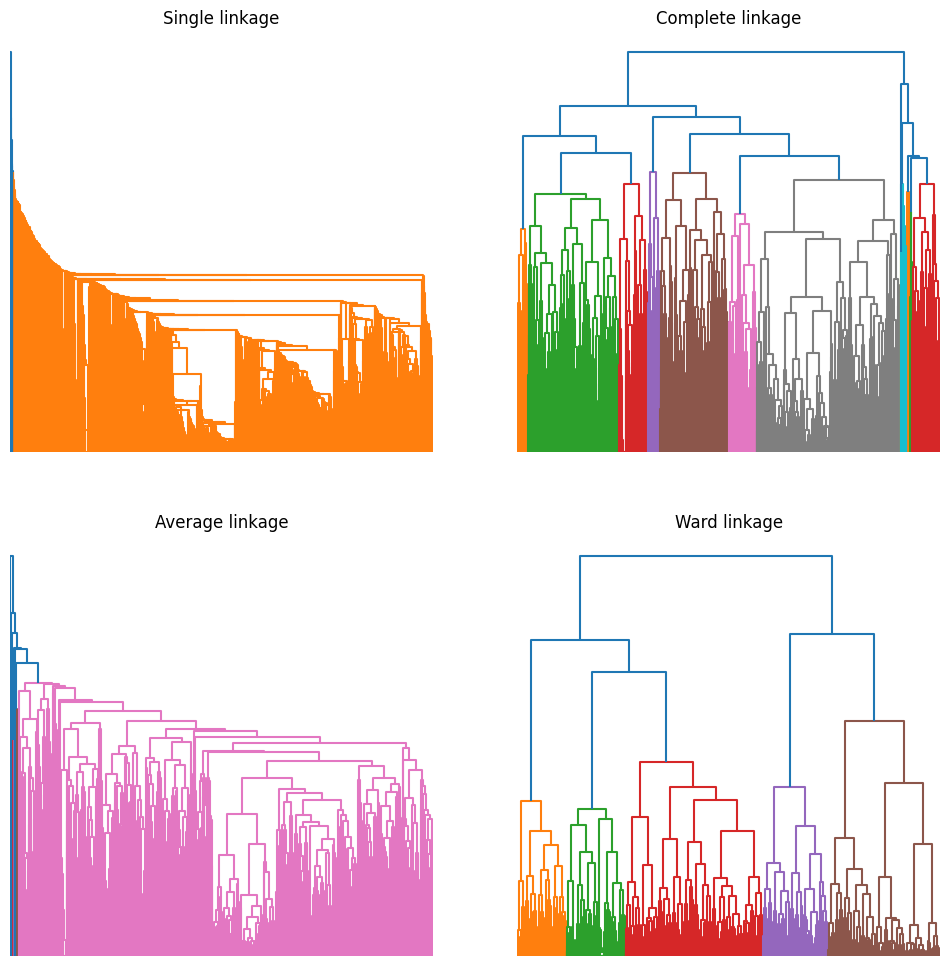

In [34]:
tree_sing, tree_cplt, tree_avrg, tree_ward = all_linkages(X_train)


Above, we plotted the graphs of the 4 types of linkage. Visually, we can see that Average and Single Linkage do not work well in clustering our data. However, Ward and Complete both seem to be viable options. Let us expand upon these two in more detail.


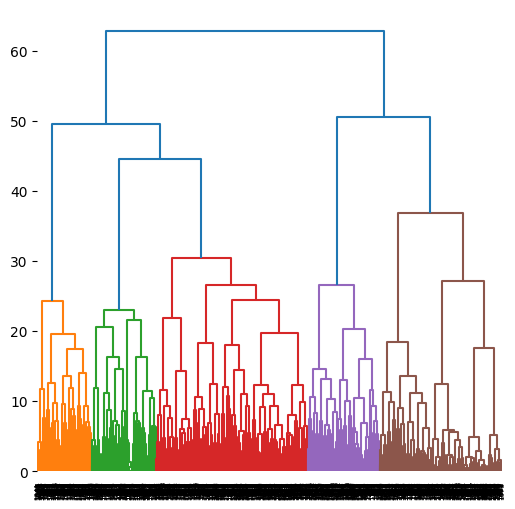

In [35]:
fig, ax = plt.subplots(figsize=(6,6))


dendrogram(tree_ward, ax=ax)
sns.despine(left=True,bottom=True)


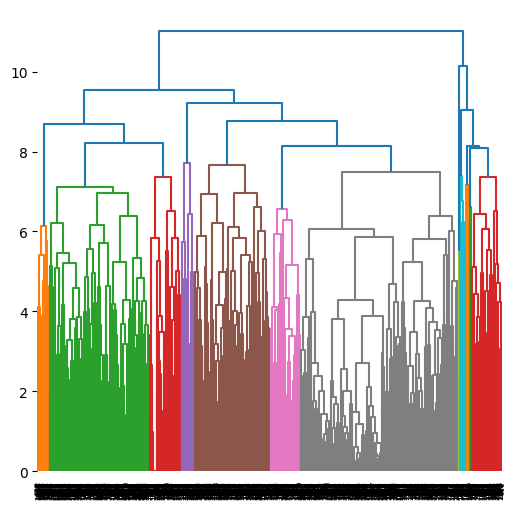

In [36]:
fig, ax = plt.subplots(figsize=(6,6))


dendrogram(tree_cplt, ax=ax)
sns.despine(left=True,bottom=True)

After plotting the two types of graphs we are considering, We can see that the optimal clustering distance for ward linkage is between 20 and 30, while the optimal clustering distance for complete linkage is between 8 to 10. Lets use these values to find the best parameters.

In [37]:
best_score = -1
best_params = None
best_type = None


for dist in [ 8, 8.5, 9, 9.5, 22, 23, 24, 25, 26, 27, 28, 29, 30]: 
   for type in [tree_ward, tree_cplt]: 
       clust = fcluster(type, criterion='distance', t=dist)
      
       # Compute adjusted Rand index
       score = adjusted_rand_score(y_train, clust)
       print(score, clust)
       # Update best score and parameters
       if score > best_score:
           best_score = score
           best_params = {'dist': dist}
           if np.array_equal(type, tree_ward):
               best_type = 'tree_ward'
           elif np.array_equal(type, tree_cplt):
               best_type = 'tree_cplt'


print("Best parameters:", best_params)
print("Best type:", best_type)
print("Best Adjusted Rand Index:", best_score)

0.12587852379381625 [66 68 61 ... 24 65 56]
0.15704702934334064 [2 1 1 ... 3 2 7]
0.1266469941280003 [60 61 56 ... 24 59 52]
0.14480933889055692 [2 1 1 ... 2 2 5]
0.1269375141042391 [53 54 49 ... 20 52 45]
0.07484543989997404 [1 1 1 ... 1 1 3]
0.12908144779319622 [47 48 43 ... 18 46 39]
0.06628826936234958 [1 1 1 ... 1 1 2]
0.220709861247327 [ 9 10  9 ...  4  9  8]
0.0 [1 1 1 ... 1 1 1]
0.220709861247327 [ 9 10  9 ...  4  9  8]
0.0 [1 1 1 ... 1 1 1]
0.21410649336181933 [8 9 8 ... 3 8 7]
0.0 [1 1 1 ... 1 1 1]
0.21400206867279617 [6 7 6 ... 2 6 5]
0.0 [1 1 1 ... 1 1 1]
0.21400206867279617 [6 7 6 ... 2 6 5]
0.0 [1 1 1 ... 1 1 1]
0.20518336891274686 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
0.273271761060468 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
0.273271761060468 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
0.273271761060468 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
Best parameters: {'dist': 28}
Best type: tree_ward
Best Adjusted Rand Index: 0.273271761060468


Despite the visually appealing results obtained from complete linkage clustering, further examination through print statements revealed its limited accuracy. Conversely, our best-performing parameters utilized the ward linkage method, with a cluster distance of 28 proving to be optimal. This observation, supported by the Adjusted Rand Index (ARI), suggests that Hierarchical Clustering is a valid approach for clustering our Obesity Data. The effectiveness of this model indicates its potential utility in uncovering meaningful clusters within our dataset.

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
